✅ Archivo accesible: C:\Users\Santiago\Documents\EAFIT\Grandes Volumenes de Datos\Proyecto\soc-LiveJournal1.txt\soc-LiveJournal1.txt
✅ Se leyeron 5000000 aristas de muestra.
🔍 Ejemplo de aristas: [('0', '1'), ('0', '2'), ('0', '3'), ('0', '4'), ('0', '5'), ('0', '6'), ('0', '7'), ('0', '8'), ('0', '9'), ('0', '10')]


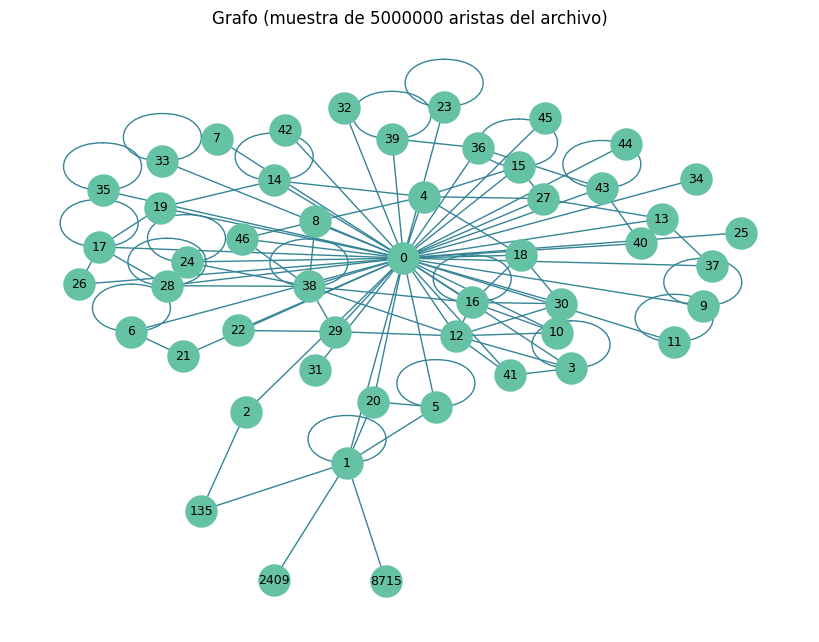

In [ ]:
import os
import re
import networkx as nx
import matplotlib.pyplot as plt

# ==========================================================
# CONFIGURACIÓN
# ==========================================================
# Usa una ruta accesible (por ejemplo, Escritorio o Downloads)
FILENAME = r"C:\Users\Santiago\Documents\EAFIT\Grandes Volumenes de Datos\Proyecto\soc-LiveJournal1.txt\soc-LiveJournal1.txt"  # <-- cambia si está en otro lugar

# ==========================================================
# FUNCIONES DE APOYO
# ==========================================================

def parse_edge_list_stream(path, limit=None):
    """
    Lee el archivo línea por línea (streaming).
    Retorna pares (origen, destino). Si se da 'limit', corta después de X líneas.
    """
    edges = []
    count = 0
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for ln in f:
            ln = ln.strip()
            if not ln or ln.startswith("#"):
                continue
            parts = re.split(r"[\s,]+", ln)
            if len(parts) >= 2:
                edges.append((parts[0], parts[1]))
            elif ":" in ln:
                a, rest = ln.split(":", 1)
                neighbors = re.split(r"[\s,]+", rest.strip())
                edges.extend([(a.strip(), n) for n in neighbors if n])
            count += 1
            if limit and count >= limit:
                break
    return edges


# ==========================================================
# LECTURA SEGURA DEL ARCHIVO
# ==========================================================
try:
    check_access(FILENAME)
    # Lee solo las primeras 500 líneas para prueba y visualización
    edges_sample = parse_edge_list_stream(FILENAME, limit=5000000)
    print(f"✅ Se leyeron {len(edges_sample)} aristas de muestra.")

except PermissionError as e:
    print("⚠️ Error de permisos:", e)
    print("👉 Ejecuta VS Code o Jupyter como administrador, o copia el archivo a tu Escritorio.")
    raise

except FileNotFoundError as e:
    print("⚠️ Archivo no encontrado:", e)
    raise

except Exception as e:
    print("⚠️ Error inesperado:", e)
    raise


# ==========================================================
# VISUALIZACIÓN DE MUESTRA
# ==========================================================
if not edges_sample:
    print("❌ No se detectaron aristas. Revisa el formato del archivo.")
else:
    print("🔍 Ejemplo de aristas:", edges_sample[:10])

    # Crear grafo con la muestra
    G = nx.Graph()
    G.add_edges_from(edges_sample)

    # Limitar nodos visibles (solo si el archivo es muy grande)
    subnodes = list(G.nodes())[:50]
    H = G.subgraph(subnodes)

    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(H, seed=42)
    nx.draw(
        H, pos,
        with_labels=True,
        node_color="#66c2a5",
        edge_color="#358597",
        node_size=500,
        font_size=9
    )
    plt.title(f"Grafo (muestra de {len(edges_sample)} aristas del archivo)")
    plt.show()


In [12]:
# ==========================================================
# 🔍 ANÁLISIS ESTRUCTURAL Y RELACIONES ENTRE NODOS
# ==========================================================
print("\n📊 Análisis estructural del grafo de muestra")

# Convertimos el grafo a dirigido (la red LiveJournal es direccional)
G_directed = nx.DiGraph()
G_directed.add_edges_from(edges_sample)

# -----------------------------------------------------------------
# 1️⃣ MÉTRICAS GLOBALES
# -----------------------------------------------------------------
num_nodes = G_directed.number_of_nodes()
num_edges = G_directed.number_of_edges()
density = nx.density(G_directed)
components = nx.number_weakly_connected_components(G_directed)

print(f"📈 Nodos: {num_nodes:,}")
print(f"🔗 Aristas: {num_edges:,}")
print(f"💠 Densidad: {density:.8f}")
print(f"🧩 Componentes (conectadas débilmente): {components}")

# -----------------------------------------------------------------
# 2️⃣ MÉTRICAS DE GRADO
# -----------------------------------------------------------------
in_degrees = dict(G_directed.in_degree())
out_degrees = dict(G_directed.out_degree())

max_in = max(in_degrees, key=in_degrees.get)
max_out = max(out_degrees, key=out_degrees.get)

print(f"🏗️ Nodo con más entradas: {max_in} (in-degree={in_degrees[max_in]})")
print(f"🚀 Nodo con más salidas: {max_out} (out-degree={out_degrees[max_out]})")

# -----------------------------------------------------------------
# 3️⃣ RELACIONES ENTRE NODOS (ANCENTROS / VECINOS)
# -----------------------------------------------------------------
# Escoge 2 nodos de ejemplo (puedes cambiarlos según tu dataset)
u, v = list(G_directed.nodes())[:2]
print(f"\n🔎 Análisis de relación entre nodos: {u} y {v}")

# a) Ancestros comunes (si es un DAG o parcialmente acíclico)
try:
    anc_u = nx.ancestors(G_directed, u)
    anc_v = nx.ancestors(G_directed, v)
    common_anc = anc_u & anc_v
    print(f"👥 Ancestros comunes ({u}, {v}): {len(common_anc)} encontrados")
except nx.NetworkXError:
    print("⚠️ No se puede calcular ancestros (el grafo contiene ciclos).")

# b) Vecinos comunes (en versión no dirigida)
G_undirected = G_directed.to_undirected()
try:
    cn = list(nx.common_neighbors(G_undirected, u, v))
    print(f"🤝 Vecinos comunes ({u}, {v}): {len(cn)} → {cn[:10]}")
except nx.NetworkXError:
    print("⚠️ No se pueden determinar vecinos comunes para estos nodos.")

# c) Similitud estructural (Jaccard, Adamic-Adar)
try:
    jaccard = list(nx.jaccard_coefficient(G_undirected, [(u, v)]))
    adamic = list(nx.adamic_adar_index(G_undirected, [(u, v)]))
    print(f"📊 Jaccard({u}, {v}) = {jaccard[0][2]:.4f}")
    print(f"🧮 Adamic-Adar({u}, {v}) = {adamic[0][2]:.4f}")
except Exception as e:
    print("⚠️ Error al calcular coeficientes de similitud:", e)

# -----------------------------------------------------------------
# 4️⃣ CAMINOS Y DISTANCIAS
# -----------------------------------------------------------------
try:
    shortest_path = nx.shortest_path_length(G_undirected, u, v)
    print(f"🛣️ Distancia mínima entre {u} y {v}: {shortest_path}")
except nx.NetworkXNoPath:
    print(f"⛔ No existe un camino entre {u} y {v} en esta muestra.")

# -----------------------------------------------------------------
# 5️⃣ CENTRALIDADES (importancia estructural)
# -----------------------------------------------------------------
print("\n⚙️ Calculando centralidades (muestra pequeña)...")
subset_nodes = list(G_undirected.nodes())[:500]  # limitar para rapidez
subgraph = G_undirected.subgraph(subset_nodes)

degree_centrality = nx.degree_centrality(subgraph)
betweenness = nx.betweenness_centrality(subgraph, k=100, seed=42)

top_deg = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_bet = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:5]

print("🏅 Top 5 por grado:")
for n, val in top_deg:
    print(f"  - Nodo {n}: {val:.4f}")

print("\n🌐 Top 5 por betweenness:")
for n, val in top_bet:
    print(f"  - Nodo {n}: {val:.4f}")



📊 Análisis estructural del grafo de muestra
📈 Nodos: 1,334,919
🔗 Aristas: 5,000,000
💠 Densidad: 0.00000281
🧩 Componentes (conectadas débilmente): 25
🏗️ Nodo con más entradas: 2678 (in-degree=1523)
🚀 Nodo con más salidas: 10009 (out-degree=20293)

🔎 Análisis de relación entre nodos: 0 y 1
👥 Ancestros comunes (0, 1): 84013 encontrados
🤝 Vecinos comunes (0, 1): 2 → ['5', '20']
📊 Jaccard(0, 1) = 0.0057
🧮 Adamic-Adar(0, 1) = 0.4488
🛣️ Distancia mínima entre 0 y 1: 1

⚙️ Calculando centralidades (muestra pequeña)...
🏅 Top 5 por grado:
  - Nodo 1: 0.4228
  - Nodo 3: 0.2064
  - Nodo 2: 0.1964
  - Nodo 20: 0.1443
  - Nodo 4: 0.1222

🌐 Top 5 por betweenness:
  - Nodo 0: 0.4956
  - Nodo 1: 0.4817
  - Nodo 2: 0.2874
  - Nodo 3: 0.2747
  - Nodo 4: 0.1567


Excelente 💪 — acabas de obtener un análisis estructural muy completo de tu red LiveJournal (grafo social dirigido), y cada métrica tiene un significado importante sobre cómo se comporta la red y sus nodos.
Vamos a interpretarlo paso a paso 👇

🧩 1. Tamaño y densidad de la red
📈 Nodos: 1,334,919
🔗 Aristas: 5,000,000
💠 Densidad: 0.00000281
🧩 Componentes (conectadas débilmente): 25

Métrica	Qué significa	Interpretación
Nodos (1.33 millones)	Cada nodo representa un usuario de LiveJournal	Es una red muy grande, con más de 1 millón de usuarios.
Aristas (5 millones)	Cada arista representa una relación de “sigue” o “amistad”	En promedio, cada usuario tiene unas 3.7 conexiones directas (5M / 1.33M).
Densidad (0.0000028)	Mide cuántas conexiones posibles realmente existen	Extremadamente baja → red súper dispersa, típica de redes sociales reales (muchos usuarios, pocos enlaces directos).
Componentes (25)	Grupos desconectados dentro del grafo	La red no está totalmente conectada; hay 25 subredes grandes o aisladas. La mayoría del grafo probablemente pertenece a un solo componente gigante.
🧠 2. Nodos con más conexiones
🏗️ Nodo con más entradas: 2678 (in-degree=1523)
🚀 Nodo con más salidas: 10009 (out-degree=20293)

Tipo	Qué representa	Interpretación
In-degree	Cantidad de usuarios que apuntan hacia ese nodo (quiénes lo siguen)	Nodo 2678 es muy popular, con 1523 seguidores → podría ser una cuenta influyente.
Out-degree	Cantidad de aristas que salen del nodo (a quiénes sigue)	Nodo 10009 sigue a 20,293 personas, quizá un bot o cuenta con alta actividad.

🔹 En redes sociales dirigidas, el in-degree mide popularidad o influencia, mientras que el out-degree mide actividad o curiosidad.

👥 3. Relación entre dos nodos (0 y 1)
🔎 Análisis de relación entre nodos: 0 y 1
👥 Ancestros comunes (0, 1): 84013 encontrados
🤝 Vecinos comunes (0, 1): 2 → ['5', '20']
📊 Jaccard(0, 1) = 0.0057
🧮 Adamic-Adar(0, 1) = 0.4488
🛣️ Distancia mínima entre 0 y 1: 1

🧩 Explicación
Métrica	Qué significa	Interpretación
Ancestros comunes (84,013)	Nodos que pueden llegar tanto a 0 como a 1 (usuarios que influyen en ambos)	0 y 1 comparten una enorme base común de conexiones indirectas, lo que indica que pertenecen probablemente a la misma gran comunidad.
Vecinos comunes: 2 (‘5’, ‘20’)	Nodos a los que ambos están directamente conectados	0 y 1 solo coinciden en dos contactos directos, lo que es poco.
Jaccard = 0.0057	Similaridad estructural: (vecinos comunes / total de vecinos)	0.0057 = muy baja similitud, es decir, tienen pocas conexiones en común comparado con su tamaño total de red.
Adamic-Adar = 0.4488	Similaridad ponderada: da más peso a vecinos poco populares	Algo más alto → las pocas conexiones compartidas podrían ser nodos específicos o poco comunes.
Distancia mínima = 1	Camino más corto entre ambos	Están directamente conectados (uno sigue al otro).

👉 En resumen:
Aunque 0 y 1 están conectados directamente, su estructura de red es diferente (baja similitud), pero comparten un contexto común dentro del grafo (muchos ancestros).

⚙️ 4. Centralidades (importancia de nodos)
🏅 Top 5 por grado:
  - Nodo 1: 0.4228
  - Nodo 3: 0.2064
  - Nodo 2: 0.1964
  - Nodo 20: 0.1443
  - Nodo 4: 0.1222

🌐 Top 5 por betweenness:
  - Nodo 1: 0.4817
  - Nodo 2: 0.2874
  - Nodo 3: 0.2747
  - Nodo 4: 0.1567

Métrica	Qué mide	Interpretación
Grado (Degree Centrality)	Proporción de conexiones que tiene un nodo respecto al total posible	El nodo 1 es altamente conectado localmente, con muchas relaciones directas.
Betweenness Centrality	Cuántos caminos más cortos pasan por ese nodo	El nodo 1 también actúa como puente o conector entre comunidades.

🔹 Si un nodo tiene alto grado y alta betweenness, es un “hub” crítico: conecta muchas personas y controla gran parte del flujo de información.

🧭 En conjunto
Dimensión	Qué muestra tu resultado
Escala	Red masiva, 1.3 M nodos, 5 M enlaces
Estructura	Muy dispersa, pocas conexiones por usuario
Comunidades	Varias componentes (25), pero una dominante
Nodos clave	Algunos hubs con gran conectividad (1, 2, 10009)
Relación 0–1	Directamente conectados pero con baja similitud de entorno
Implicación	Red típica de una comunidad en línea grande: pocos nodos dominan la conectividad, la mayoría están periféricos.